# Análisis del dataset


Este dataset esta compuesto por imagenes con el siguiente formato:
- Imagenes 200x200 pixeles RGB
- Nombre de la imagen : edad_año_fechaDeImagen.jpg

Para trabajar con este dataset hemos decidido implementar una clase que herede de Dataset (perteneciente a pytorch)

Nota: Durante el proceso hemos visto que habia ciertas imagenes que no tenian el formato correcto y hemos decidido eliminarlas; luego es muy importante que se use la carpeta UTKFace que esta incluida en el proyecto

In [1]:
#Vamos a trabajar con pytorch y este permite crear tu propio dataset
from torch.utils.data import Dataset
import os
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from itertools import islice
from torch.utils.data import DataLoader
import random
import data

class Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = os.listdir(img_dir) #lista de los nombres de las fotos
        self.img_dir = img_dir #Ruta principal donde estan las imagenes
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        nombre_imagen = os.path.join(self.img_dir, self.img_labels[idx])  #Ruta completa
        imagen =  Image.open(nombre_imagen) #abrimos la imagen

        # Extraer la info del nombre del archivo
        parts = self.img_labels[idx].split('_')  # Separar por guiones bajos

        age = torch.tensor(int(parts[0])).float()  # Primer elemento: la edad
        gender = torch.tensor(int(parts[1]))  # Segundo elemento: el género
        race = torch.tensor(int(parts[2]))
        
        if self.transform:

          imagen = self.transform(imagen)  # Aplicar transformaciones a la imagen

        if self.target_transform:
          age = torch.tensor(int(self.target_transform(age)))  # Aplicar transformaciones a la edad (opcional)

        return imagen, age,gender,race

In [2]:
utk_ruta = "./UTKFace"
GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negro','Asiático','Indio','Otros')
EDADES = ('0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-120')

Veamos una muestra de como son los imagenes:

In [5]:
def mostrarImg(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Esto normalizara las imagenes
dataset = Dataset(utk_ruta,transform=transform) #Pasamos las imagenes a la estructura de datos
print(dataset.__len__())

23706


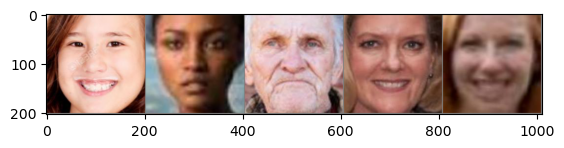

Edad:    12.0  25.0  90.0  43.0  33.0
Genero: Mujer Mujer Hombre Mujer Mujer
Raza:   Asiático Negro Blanco Blanco Blanco


In [4]:
#Cogemos 3 fotos aleatorias del dataset
loader = DataLoader(dataset, batch_size=5, shuffle=True)
imagenes, edades, generos, razas = next(iter(loader))

mostrarImg(imagenes)
print('Edad:  ',' '.join('%5s' % edades[j].item() for j in range(5)))
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(5)))
print('Raza:  ',' '.join('%5s' % RAZA[razas[j].item()] for j in range(5)))



Vamos a recopilar los datos de las personas para estudiarlos posteriormente:

In [5]:
#Recopilacion de datos
generos =[]
edades = []
razas = []

for imagen  in dataset:
    imagen,edad,genero, raza = imagen

    edades.append(edad.item())
    generos.append(genero.item())
    razas.append(raza.item())

generos = np.array(generos)
edades = np.array(edades)
razas = np.array(razas)


Ahora mostramos un grafica de barras para el genero y y la raza:

Text(0.5, 1.0, 'Raza')

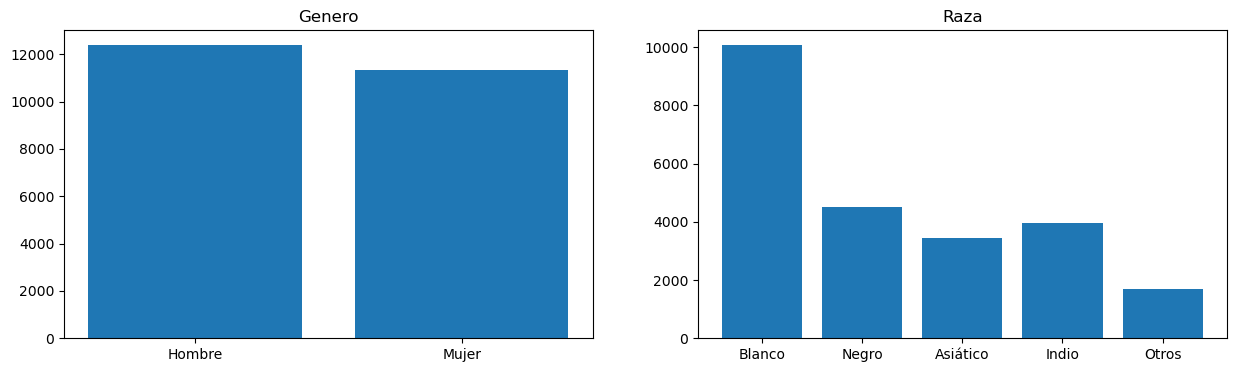

In [ ]:
_, frecuencia_generos = np.unique(generos, return_counts=True)
_, frecuencia_razas = np.unique(razas, return_counts=True)

# Dibujar diagramas de barras
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].bar(x = GENERO,height = frecuencia_generos)
axs[0].set_title("Genero")
axs[1].bar(x = RAZA,height = frecuencia_razas)
axs[1].set_title("Raza")


Vemos que en el genero el dataset esta bastante equilibrado, hay casi la misma cantidad de mujeres que de hombres. Sin embargo, respecto a la raza, hay un reparto desigual habiendo un dominion de gente Blanca respeto a las demas. Esto podrá tener efectos negativos a la hora de entrenar nuestos modelos, provocando un sesgo o tendencia de eleccion a personas blancas.

Para la edad, como el rango es muy amplio( entre 0 y 120 años) hemos decidio clasificarlo por rangos de 10 años para facilitar la visualizacion de las graficas y su entendiemiento:

<BarContainer object of 12 artists>

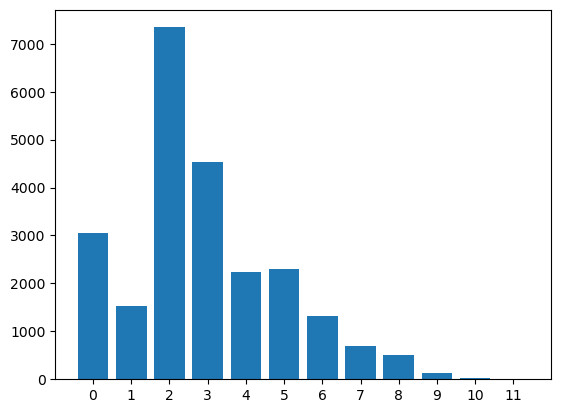

In [58]:
def clasificarEdad(edad):
    return edad//10

edades_clasificadas = clasificarEdad(np.array(edades))
valores_unicos, frecuencias = np.unique(edades_clasificadas, return_counts=True)
fig, ax = plt.subplots()
ax.bar(x =['0','1','2','3','4','5','6','7','8','9','10','11'], height = frecuencias)



Vemos que en general la distribucion por edades no es proporcional. Abunda mas la gente con edades entre 20 y 29 años que el resto